In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
import matplotlib
import scipy
from segmentation_models_pytorch import utils as smp_utils

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# print('Current directory:', dname)
# os.chdir(dname)

In [4]:
DATA_DIR = './'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'train')
y_valid_dir = os.path.join(DATA_DIR, 'train_annot')

x_test_dir = os.path.join(DATA_DIR, 'train')
y_test_dir = os.path.join(DATA_DIR, 'train_annot')

In [6]:
# helper function for data visualization
def visualize(image, mask):
    """PLot images in one row."""
    n = mask.shape[2]+1
    plt.figure(figsize=(n*6, 5))
    # for i, (name, image) in enumerate(images.items()):

    plt.subplot(1, n, 1)
    plt.xticks([])
    plt.yticks([])
    # plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
    
    cmaps = [
        matplotlib.colors.ListedColormap(['black', 'red']),
        matplotlib.colors.ListedColormap(['black', 'orange']),
        matplotlib.colors.ListedColormap(['black', 'blue']),
        matplotlib.colors.ListedColormap(['black', 'pink']),
        matplotlib.colors.ListedColormap(['black', 'green']),
        matplotlib.colors.ListedColormap(['black', 'yellow']),
        matplotlib.colors.ListedColormap(['black', 'red']),
    ]
    names = ['C', 'Ca', 'Mg', 'Na', 'O', 'S', 'Cl']
    
    for j in range(7):
        plt.subplot(1, n, j + 2)
        plt.xticks([])
        plt.yticks([])
        name = names[j]
        plt.title(name)
        plt.imshow(mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
    plt.show()

In [7]:
class Dataset(BaseDataset):
    """Setup Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        # list file names in the self.ids list
        self.sem_ids = os.listdir(images_dir)
        self.label_ids = os.listdir(masks_dir)
        
        self.sem_ids.sort()
        self.label_ids.sort()
        
        if self.sem_ids[0].startswith('.'):
            self.sem_ids.pop(0)
            
        if self.label_ids[0].startswith('.'):
            self.label_ids.pop(0)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.sem_ids]
        self.masks_fps = [os.path.join(masks_dir, label_id) for label_id in self.label_ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # converting the file dimension in [N, C, H, W] order
        # image = np.transpose(image, (2, 0, 1))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat = scipy.io.loadmat(self.masks_fps[i])
        mask = mat['label']
        mask = np.transpose(mask, (1, 2, 0))
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.sem_ids)

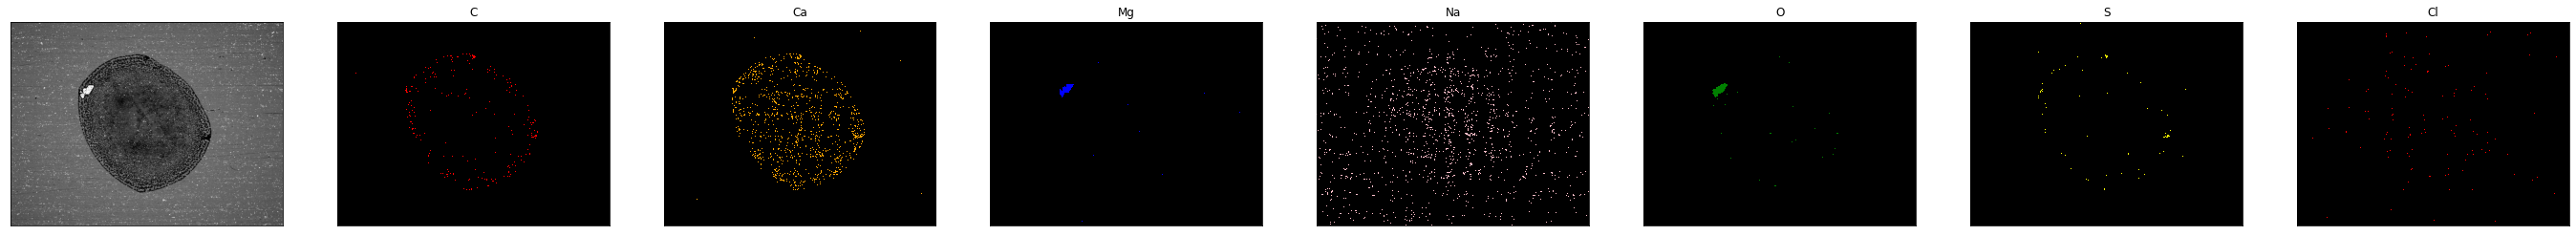

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[5]
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [9]:
def get_training_augmentation():
    
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [10]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(1920, 2560, 3) (1920, 2560, 7)


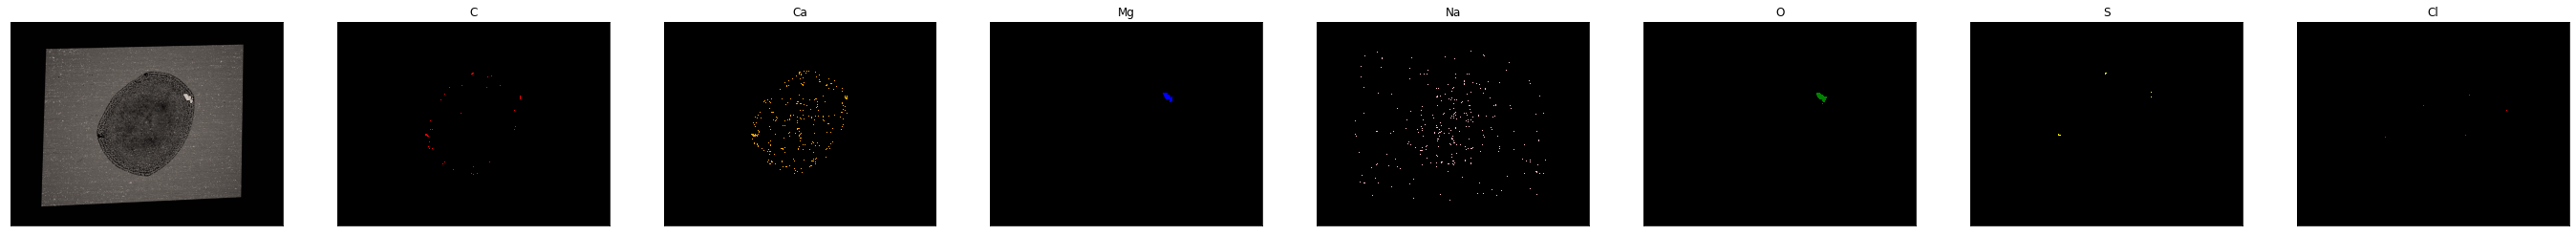

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)
image, mask = augmented_dataset[5]
print(image.shape, mask.shape)
visualize(image=image, mask=mask)

In [12]:
torch.cuda.empty_cache()
# torch.cuda.set_per_process_memory_fraction(0.9, 0)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [13]:
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights='imagenet',
    classes = 7, 
    activation='sigmoid'
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [16]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [17]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [19]:
loss = smp.losses.DiceLoss("multilabel")
loss.__name__ = 'Dice_loss'

metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [20]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True
)

In [21]:
max_score = 0

#################################
n = np.random.choice(len(train_dataset))

train_dataset_vis = Dataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn)
)

In [22]:
# image_vis = train_dataset_vis[n][0].astype('uint8')
# image, gt_mask = train_dataset[n]

# gt_mask = gt_mask.squeeze()

# x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# pr_mask = model.predict(x_tensor)
# pr_mask = (pr_mask.squeeze().cpu().numpy().round())

In [23]:
best_model = torch.load('./best_model.pth')


Epoch: 0
valid: 100%|██████████| 313/313 [08:39<00:00,  1.66s/it, Dice_loss - 0.8533, iou_score - 0.1116] 
Model saved!
(3, 1920, 2560)
(1920, 2560, 7)


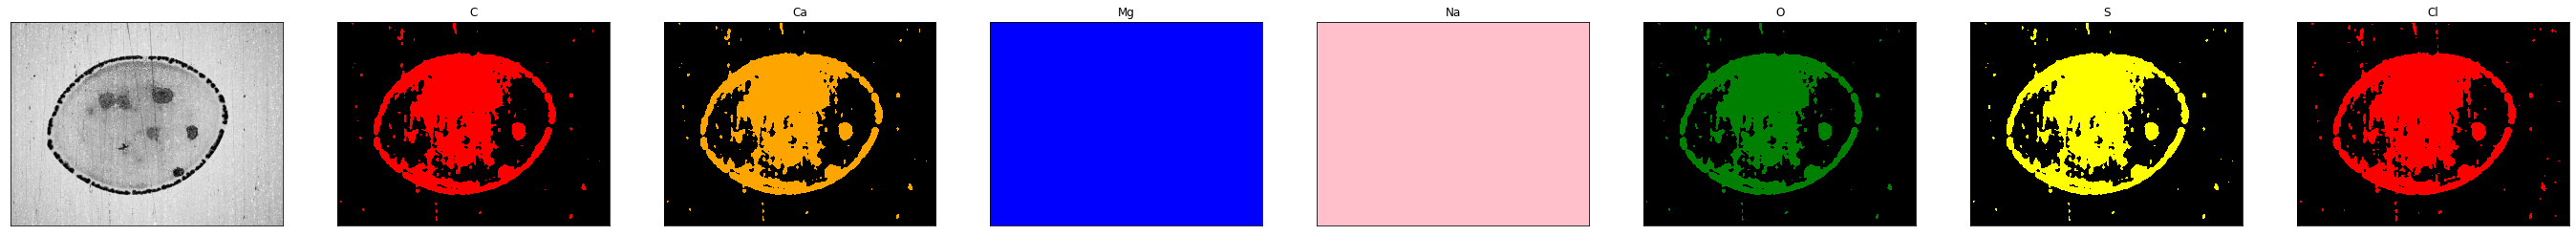


Epoch: 1
train:  43%|████▎     | 136/313 [06:06<07:56,  2.69s/it, Dice_loss - 0.8592, iou_score - 0.1027]


KeyboardInterrupt: 

In [24]:
for i in range(0, 40):
        
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    if i % 50 == 0:
        n = np.random.choice(len(test_dataset))
        image_vis = test_dataset_vis[n][0].astype('uint8')
        image, gt_mask = test_dataset[n]
        print(image.shape)
        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()
        pr_mask = np.transpose(pr_mask, (1, 2, 0))
        print(pr_mask.shape)
        visualize(
            image=image_vis, 
            mask=pr_mask
        )

In [ ]:
print(max_score)

In [ ]:
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
    pr_mask = np.transpose(pr_mask, (1, 2, 0))
    

In [ ]:
for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    if i % 10 == 0:
        n = np.random.choice(len(test_dataset))
        image_vis = test_dataset_vis[n][0].astype('uint8')
        image, gt_mask = test_dataset[n]
        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()
        pr_mask = np.transpose(pr_mask, (1, 2, 0))
        visualize(
            image=image_vis, 
            mask=pr_mask
        )

In [ ]:
# evaluate model on test set
test_epoch = smp_utils.train.ValidEpoch(
    model='best_model.pth',
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [ ]:
logs = test_epoch.run(test_dataloader)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
    pr_mask = np.transpose(pr_mask, (1, 2, 0))
    visualize(
        image=image_vis, 
        mask=pr_mask
    )